In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip3 install numpy opencv-python==3.4.2.17 opencv-contrib-python==3.4.2.17

     |████████████████████████████████| 25.0 MB 1.2 MB/s 
     |████████████████████████████████| 30.6 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
from random import randrange
import matplotlib.pyplot as plt
import numpy as np
import cv2
figsize = (10, 10)

In [17]:
'''
rgb_l = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/left.jpg'), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("/content/drive/MyDrive/right.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)
'''



rgb_l = cv2.cvtColor(cv2.imread('000003 copy.jpg'), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("000003 copy 2.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)



Text(0.5, 1.0, 'keypoints')

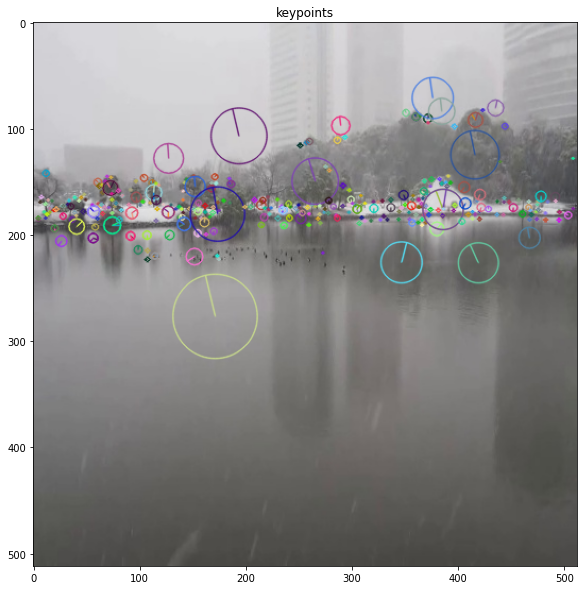

In [18]:
# use orb if sift is not installed
#feature_extractor = cv2.SIFT_create()
feature_extractor = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with chosen feature_extractor
kp_l, desc_l = feature_extractor.detectAndCompute(gray_l, None)
kp_r, desc_r = feature_extractor.detectAndCompute(gray_r, None)

test = cv2.drawKeypoints(rgb_l, kp_l, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=figsize)
plt.imshow(test)
plt.title("keypoints")

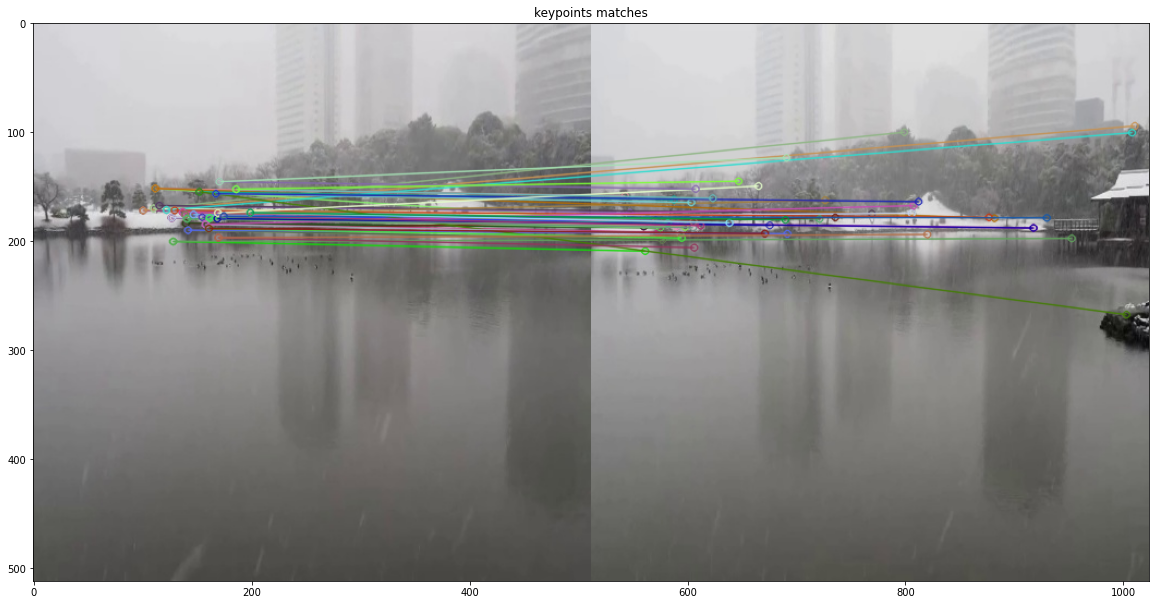

In [19]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc_l, desc_r, k=2)

# Apply ratio test
good_and_second_good_match_list = []
for m in matches:
    if m[0].distance/m[1].distance < 0.5:
        good_and_second_good_match_list.append(m)
good_match_arr = np.asarray(good_and_second_good_match_list)[:,0]

# show only 30 matches
im_matches = cv2.drawMatchesKnn(rgb_l, kp_l, rgb_r, kp_r,
                                good_and_second_good_match_list[0:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 20))
plt.imshow(im_matches)
plt.title("keypoints matches")
plt.show()

In [20]:
good_kp_l = np.array([kp_l[m.queryIdx].pt for m in good_match_arr])
good_kp_r = np.array([kp_r[m.trainIdx].pt for m in good_match_arr])
H, masked = cv2.findHomography(good_kp_r, good_kp_l, cv2.RANSAC, 5.0)

print(H)

[[ 8.58548246e-01  2.11522787e-03  8.42860489e+01]
 [-5.37379373e-02  9.46819470e-01  2.64045388e+00]
 [-2.85798673e-04  2.06371463e-05  1.00000000e+00]]


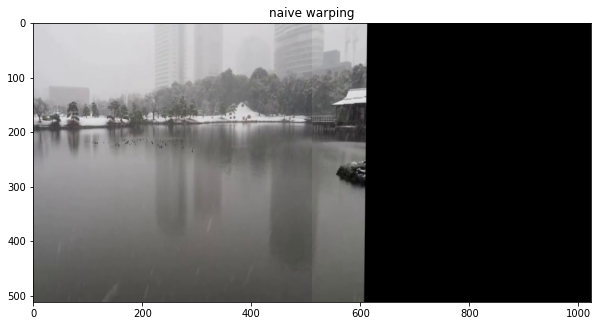

In [21]:
rgb_r_warped = cv2.warpPerspective(rgb_r, H, (rgb_l.shape[1] + rgb_r.shape[1], rgb_l.shape[0]))
rgb_r_warped[0:rgb_l.shape[0], 0:rgb_l.shape[1]] = rgb_l

plt.figure(figsize=figsize)
plt.imshow(rgb_r_warped)
plt.title("naive warping")
plt.show()

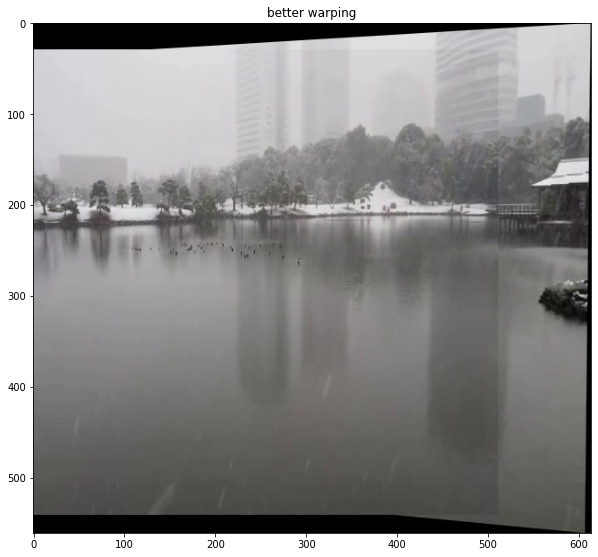

In [22]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H
    from: https://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective
    '''
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    result = cv2.warpPerspective(img2, Ht@H, (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1], t[0]:w1+t[0]] = img1
    return result


result = warpTwoImages(rgb_l, rgb_r, H)

plt.figure(figsize=figsize)
plt.imshow(result)
plt.title("better warping")
plt.show()